# New York Fare Classification

Objectives 
- learn embeddings
- learn dropout
- serve as another case study

Embedding
- a very powerful concept
- replaces label-encoding and one-hot encoding
  - label-encoding:  turns category into numbers
  - one-hot encodings: turns category into cols
- In neural network, we don't have to....
  - we instead assign a vector of numbers for each category
  - Let's say I have 1000 samples, one col with two categories (morning, afternoon)
    - SHAPE: (1000, 1)
  - But for neural net. we can first create random vectors representing each cat.
    - Usually half of the categories
    - morning: [1,5,0.3,2,5]
    - afternoon: [4,3,0.2,1,0.9]
  - Sape of the embeddings: SHAPE: (1000, 2, 5)

In [163]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. ETL: Load the NYC Taxi Fares dataset

In [164]:
df = pd.read_csv('../data/NYCTaxiFares.csv')
df.head()
#1. Convert UTC to NY time
#2. Extract hours, am/pm days as features
#3. fare_class is our y/target/label
#4. engineer some distance feature

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [165]:
df['fare_class'].value_counts(normalize=True)
#0 means less than 10 dollars
#1 means greter than or equal to 10 dollars
#Upsampling - SMOTE
#Downsapling - ?
#I think there is a library imblearn - take a look
#Remember, if you cross-validation, do it during cross validation
#Basically, no data leak...

0    0.666667
1    0.333333
Name: fare_class, dtype: float64

## 2. EDA

- Today we skip this part...

## 3. Feature Engineering

### Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{align} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{align}$



In [166]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d


In [167]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [168]:
#Create a column called hav_dis inside df using this function

df['hav_dis'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [169]:
df['hav_dis'].describe()

count    120000.000000
mean          3.322160
std           3.337004
min           0.010208
25%           1.316428
50%           2.237084
75%           4.034564
max          28.846365
Name: hav_dis, dtype: float64

<AxesSubplot: xlabel='fare_class', ylabel='hav_dis'>

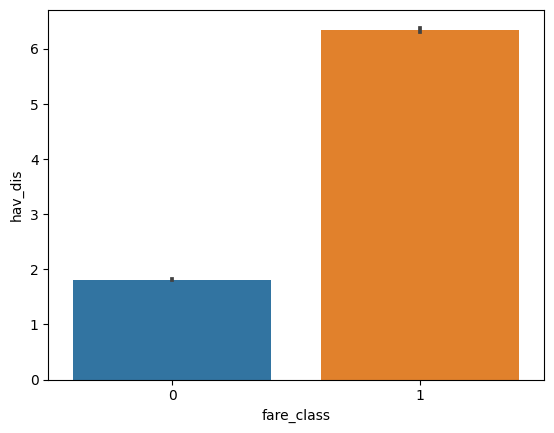

In [170]:
#Bi-variate analysis between hav_dis and fare_class
sns.barplot(x = 'fare_class',
            y = 'hav_dis',
            data = df)

<AxesSubplot: xlabel='fare_class', ylabel='hav_dis'>

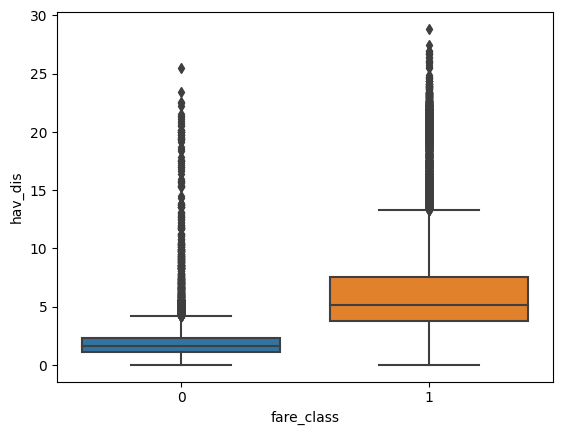

In [171]:
sns.boxplot(x = df.fare_class, y = df.hav_dis)

## 4. Feature Extraction
1. Convert UTC to NY time
2. Extract houts, am/pm ...

In [172]:
#what is the time difference between UTC and New York....
df['new_york_time'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)

In [173]:
#hour  - df['new_york_time'].dt.hour
#day   - df['new_york_time'].dt.strftime("%a")
#am/pm - np.where(hour < 12, 'am', 'pm')
#np.where(condition, if true, if false)
df['hour'] = df['new_york_time'].dt.hour
df['day']  = df['new_york_time'].dt.strftime("%a")
df['ampm'] = np.where(df['hour'] < 12, 'am', 'pm')


In [174]:
#help me write a simple assert function
#there should be no more than 24 hours
from array import array


assert len(df['hour'].unique()) <=24 , "More than 24 hours"
assert df['hour'].min() == 0, "Some negative hours"
assert df['hour'].max() == 23, "Not a normal time system"

#there should be no more than 7 days
assert len(df['day'].unique()) == 7 , "Something is not Mon-Sun"

#there should be only am and pm
assert (df['ampm'].unique() == np.array(['am', 'pm'])).all()

In [175]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'hav_dis', 'new_york_time', 'hour', 'day', 'ampm'],
      dtype='object')

## 5. Define Embeddings

In [176]:
#Columns
cat_cols = ['hour', 'ampm', 'day']
cont_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hav_dis']

y = ['fare_class']

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   pickup_datetime    120000 non-null  object        
 1   fare_amount        120000 non-null  float64       
 2   fare_class         120000 non-null  int64         
 3   pickup_longitude   120000 non-null  float64       
 4   pickup_latitude    120000 non-null  float64       
 5   dropoff_longitude  120000 non-null  float64       
 6   dropoff_latitude   120000 non-null  float64       
 7   passenger_count    120000 non-null  int64         
 8   hav_dis            120000 non-null  float64       
 9   new_york_time      120000 non-null  datetime64[ns]
 10  hour               120000 non-null  int64         
 11  day                120000 non-null  object        
 12  ampm               120000 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(3), 

In [178]:
#There is a dtype called category
#Which will neatly turns into integers
#Basically it is like label ancoding, but much more
#Why we need to turn into category first
#

for col in cat_cols:
    df[col] = df[col].astype('category')

In [179]:
df['ampm'].unique()

['am', 'pm']
Categories (2, object): ['am', 'pm']

In [180]:
df['ampm'].cat.categories

Index(['am', 'pm'], dtype='object')

In [181]:
df['ampm'].cat.codes

0         0
1         0
2         0
3         1
4         1
         ..
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8

In [182]:
df['ampm'].cat.codes.values

array([0, 0, 0, ..., 1, 0, 1], dtype=int8)

## 6. Cleaning

In [183]:
df.isna().sum()

pickup_datetime      0
fare_amount          0
fare_class           0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hav_dis              0
new_york_time        0
hour                 0
day                  0
ampm                 0
dtype: int64

## 7. Define X and y

In [184]:
#Stack the hours, am, pm and days as one vector

hr = df['hour'].cat.codes.values
ampm = df['ampm'].cat.codes.values
day = df['day'].cat.codes.values

time = np.stack([hr, ampm, day], 1)

time[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [185]:
time.shape # (120000 samples, 3 features)

(120000, 3)

In [186]:
#Convert this into a tensor
time = torch.tensor(time, dtype=torch.int64)
time[:3]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2]])

In [187]:
cont_cols 

['pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'hav_dis']

In [188]:
# Similarly we want to stack cont_cols into a vector of size 6
# conts = np.stack([df[col].values for col in cont_cols], 1)
# conts = torch.tensor(conts, dtype=torch.float)


In [189]:
#similarly, we want to stack them into a vector of size 6
lat1  = df['pickup_latitude'].values  #.values give you the numpy vector
lat2  = df['dropoff_latitude'].values
long1 = df['pickup_longitude'].values
long2 = df['dropoff_longitude'].values
ps_count = df['passenger_count'].values
hav_dis  = df['hav_dis'].values
#use list comprehension
#[df[col].values for col in cont_cols]

conts = np.stack([lat1, lat2, long1, long2, ps_count, hav_dis], 1)

#turn this into tensor...
conts = torch.tensor(conts, dtype=torch.float32)

conts[:4]

tensor([[ 40.7305,  40.7447, -73.9924, -73.9755,   1.0000,   2.1263],
        [ 40.7406,  40.7441, -73.9901, -73.9742,   1.0000,   1.3923],
        [ 40.7511,  40.7662, -73.9941, -73.9601,   2.0000,   3.3268],
        [ 40.7564,  40.7482, -73.9905, -73.9712,   1.0000,   1.8641]])

In [190]:
conts.shape  #(120000, 6)

torch.Size([120000, 6])

In [191]:
#Finally we need to the y, to be a tensor

#y = torch.tensor(df[y].values)

In [192]:
#y.shape

In [193]:
y = torch.tensor(df[y].values).flatten()

In [194]:
y.shape

torch.Size([120000])

## 8. Determine the embedding size
- Two ways
    - Randomly pick a size 
        - min(50 , unique/2) 
    - Specify a size

In [195]:
# Get the size of all cat. cols

cat_size = [len(df[col].cat.categories) for col in cat_cols]
#cat_size [24, 2, 7]

In [196]:
emb_size = [(size, min(50, size//2)) for size in cat_size]
emb_size

[(24, 12), (2, 1), (7, 3)]

## 9 . Ilustrate how embedding layer works

In [197]:
sample = time [:1]
sample

tensor([[4, 0, 1]])

In [198]:
# Expected output after embedding of sample
#[[[12 numbers]], [[1 number]], [[3 numbers]]]

# Expected output after embedding of 2 sample
#[[[12 numbers], [12 numbers]], [[1 number],[1 number]], [[3 numbers],[3 numbers]]]

In [199]:
#emb_size: [(24, 12), (2, 1), (7, 3)]
#but pyTorch does not have a list of nn.Embedding
#if you want pyTorch to have a list of layers, use nn.ModuleList
embed_layer = nn.ModuleList([nn.Embedding(unique, emb_s) for unique, emb_s in emb_size])


In [200]:
embed_layer

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 3)
)

In [201]:
#Empty embedding
import enum


sample_embedding = []

for i, e in enumerate (embed_layer):
    print(i)
    print(e)

0
Embedding(24, 12)
1
Embedding(2, 1)
2
Embedding(7, 3)


In [202]:
for i, e in enumerate (embed_layer):
    print(e(sample[:, i])) # Aply embedding layer to column i
                  #Apply embedding 0 to column 0

tensor([[ 0.2967, -0.6078, -1.1017, -0.9775, -2.8168,  0.1428,  0.8975, -0.9625,
         -0.3294,  0.3893,  0.1269,  1.0664]], grad_fn=<EmbeddingBackward0>)
tensor([[-0.3215]], grad_fn=<EmbeddingBackward0>)
tensor([[1.1506, 0.7498, 0.7561]], grad_fn=<EmbeddingBackward0>)


In [203]:
twosamples = time [:2]
twosamples

tensor([[ 4,  0,  1],
        [11,  0,  2]])

In [204]:
# In coding we want to concat 
sample_embedding = []

for i, e in enumerate(embed_layer):
    sample_embedding.append(e(twosamples[:, i])) #apply embedding layer to column i
                                                 #apply embedding layer 0 to column 0

In [205]:
sample_embedding

[tensor([[ 0.2967, -0.6078, -1.1017, -0.9775, -2.8168,  0.1428,  0.8975, -0.9625,
          -0.3294,  0.3893,  0.1269,  1.0664],
         [ 1.7774,  0.4407, -0.6142,  0.7328, -0.5284,  1.7776, -0.0924,  1.5440,
          -1.6368, -2.2126,  0.8129, -0.3628]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.3215],
         [-0.3215]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.1506,  0.7498,  0.7561],
         [ 1.3287,  1.1451, -0.7192]], grad_fn=<EmbeddingBackward0>)]

In [206]:
# in coding, we want to concat all these embeddings, into one vector
final_embedding = torch.cat(sample_embedding, 1)

final_embedding

tensor([[ 0.2967, -0.6078, -1.1017, -0.9775, -2.8168,  0.1428,  0.8975, -0.9625,
         -0.3294,  0.3893,  0.1269,  1.0664, -0.3215,  1.1506,  0.7498,  0.7561],
        [ 1.7774,  0.4407, -0.6142,  0.7328, -0.5284,  1.7776, -0.0924,  1.5440,
         -1.6368, -2.2126,  0.8129, -0.3628, -0.3215,  1.3287,  1.1451, -0.7192]],
       grad_fn=<CatBackward0>)

In [207]:
#nn.Dropout
#Define dropout layer
dl = nn.Dropout(0.5)

In [208]:
final_embedding = dl(final_embedding)
final_embedding 

tensor([[ 0.0000, -1.2156, -2.2035, -1.9549, -5.6337,  0.2857,  0.0000, -1.9251,
         -0.6587,  0.0000,  0.0000,  2.1327, -0.6430,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.8813, -1.2284,  1.4656, -1.0568,  3.5552, -0.0000,  3.0880,
         -3.2735, -4.4253,  0.0000, -0.7256, -0.0000,  0.0000,  0.0000, -1.4384]],
       grad_fn=<MulBackward0>)

In [209]:
#batch_norm1d = nn.BatchNorm1d(6)

In [210]:
#sample_count  = sample[]

In [211]:
# output = batch_norm1d(sample_count)
# output

In [213]:
class someNN(nn.Module):
    
    def __init__(self, emb_size, cont_size, out_size, layer_size = [200, 100], p=0.5):
        super().__init__()
        self.embed_layer = nn.ModuleList([nn.Embedding(unique, emb_s) for unique, emb_s in emb_size])
        self.dropout     = nn.Dropout(p)
        self.batchnorm1d = nn.BatchNorm1d(cont_size)
        
        #calculate input_size
        cat_size = sum(emb_s for _, emb_s in emb_size)
        input_size = cat_size + cont_size
        
        #linear(input_size, 200) -> relu -> batchnorm -> dropout
        #linear(200, 100) -> relu -> batchnorm -> dropout
        #linear(100, out_size)
        layerlist = []
        for i in layer_size:
            layerlist.append(nn.Linear(input_size, i))  #(input_size, 200)
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            input_size = i
        layerlist.append(nn.Linear(layer_size[-1], out_size))
        
        self.layers = nn.Sequential(*layerlist)
            
    def forward(self, x_cat, x_cont):
        #x_cat:  (120000, 3)
        #x_cont: (120000, 6)
        embeddings = []
        for i, e in enumerate(self.embed_layer):
            embeddings.append(e(x_cat[:, i]))
        x = torch.cat(embeddings, 1)  
        #x: (120000, 16)
        x = self.dropout(x)
        
        x_cont = self.batchnorm1d(x_cont)  
        #x_cont: (120000, 6)
        
        x = torch.cat([x, x_cont], 1)
        #x: (120000, 24)
        
        x = self.layers(x)
        
        return x

## Debugging

In [ ]:
#model = someNN(emb_size, 2)
sample_size = 3
cat_size = 3
cont_size = 6
p = 0.5
x_cat_hour = torch.randint(0,24, (sample_size, 1))
x_cat_hour = torch.randint(0,2, (sample_size, 1))
x_cat_day = torch.randint(0,7, (sample_size, 1))
x_cat_example = 
x_cat = torch.randint(sample_size, cat_size)
x_cont = torch.randint(sample_size, cont_size)

In [ ]:
#output = 

## Training

In [216]:
model = someNN(emb_size, conts.shape[1], len(y.unique()))

In [217]:
#define loss function 
J_fn = nn.CrossEntropyLoss()

In [218]:
#define optimizer (you can try use Adam)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
#Adam have dynamic learning schedules....
#but it is NOT proven that Adam is better than SGD....

In [219]:
y.shape

torch.Size([120000])

In [221]:
#why you not use 120000, too lazy to wait
#why you don't use dataloader, because our data is small, only 9 features....

#train test split
train_size = 60000
test_size  = 12000

#use your numpy indexing technique
cat_train = time[:train_size]
cat_test  = time[train_size:test_size+train_size]
con_train = conts[:train_size]
con_test  = conts[train_size:test_size+train_size]
y_train   = y[:train_size]
y_test    = y[train_size:test_size+train_size]



In [222]:
epochs = 100

losses = []

for i in range(epochs):
    yhat = model(cat_train, con_train)
    loss = J_fn(yhat, y_train)
    losses.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 25 == 1:
        print(f"Epoch: {i}; Loss: {loss:.2f}")


Epoch: 1; Loss: 0.61
Epoch: 26; Loss: 0.28
Epoch: 51; Loss: 0.27
Epoch: 76; Loss: 0.27


## 11. Inference / Testing

In [223]:
from sklearn.metrics import accuracy_score

with torch.no_grad():
    yhat = model(cat_test, con_test)
    loss = J_fn(yhat, y_test)
    predicted = torch.max(yhat, 1)[1]
    acc  = accuracy_score(predicted, y_test)
    
print(acc)


0.9020833333333333





8. Save the model